# Pedestrian Detection in Penn-Fudan

**Problem Statement:** Object detection is a fundamental challenge in Computer Vision that involves identifying the presence, location, and type of objects within an image. In this project, we focus on pedestrian detection using the Penn-Fudan Database for Pedestrian Detection.

The following code is provided to help you get started. We recommend using GPUs train the models as object detection can be very intensive even using relatively simple vision models.

## 1. Install and Import Dependencies

In [11]:
# !pip install torchvision matplotlib pillow

import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

import torch
import torch.utils.data
import torchvision
from torchvision import transforms as T

# Feel free to add additional packages here

In [10]:
# Checks which device to use (Datahub GPU is either RTX 2070 or RTX 2080)
print(f"PyTorch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Using device: {device}")

PyTorch version: 2.2.1+cu121
Torchvision version: 0.17.1+cu121
CUDA available: False
Using device: cpu


## 2. Download the Penn-Fudan Dataset

The following code reads in the Penn-Fudan dataset from the website and saves it as a data folder in the root directory. If you are having trouble download the dataset using the URL, try manually downloading the zip file directly from their website.

 **You only need to run this code once.**

In [2]:
# Download and extract the Penn-Fudan dataset
DATA_DIR = './data'
DATASET_URL = 'https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip'

os.makedirs(DATA_DIR, exist_ok=True)

if not os.path.exists(os.path.join(DATA_DIR, 'PennFudanPed')):
    print("Downloading Penn-Fudan dataset...")
    !wget -q {DATASET_URL} -O {DATA_DIR}/PennFudanPed.zip
    !unzip -q {DATA_DIR}/PennFudanPed.zip -d {DATA_DIR}
    !rm {DATA_DIR}/PennFudanPed.zip
    print("Download complete!")
else:
    print("Dataset already exists.")

# List the dataset structure
dataset_root = os.path.join(DATA_DIR, 'PennFudanPed')
print(f"\nDataset contents: {os.listdir(dataset_root)}")
print(f"Number of images: {len(os.listdir(os.path.join(dataset_root, 'PNGImages')))}")
print(f"Number of masks: {len(os.listdir(os.path.join(dataset_root, 'PedMasks')))}")

Download complete!

Dataset contents: ['Annotation', 'PedMasks', 'PNGImages', 'added-object-list.txt', 'readme.txt']
Number of images: 170
Number of masks: 170


## 3. Visualize the Data

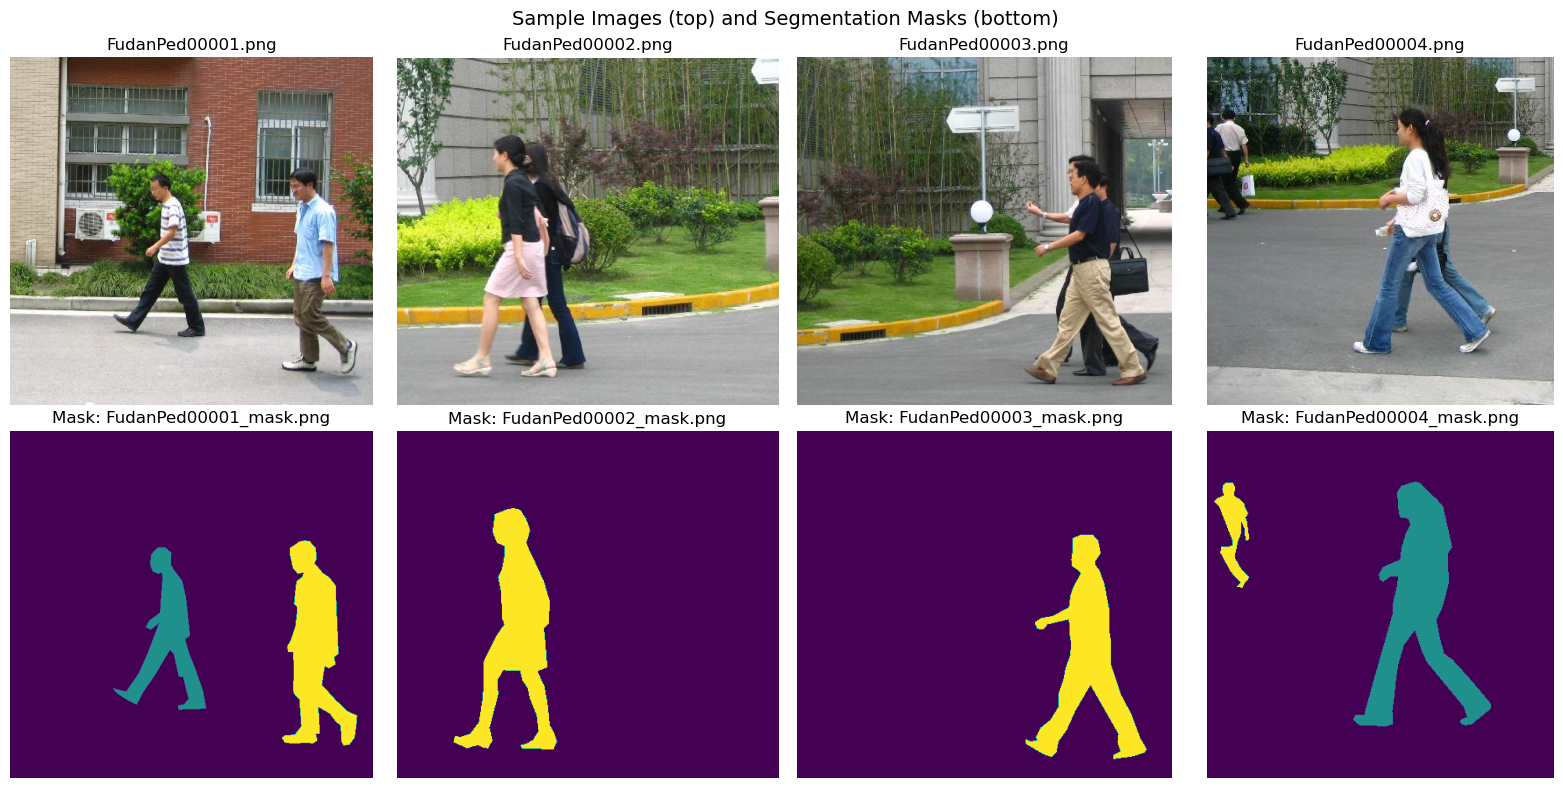

In [3]:
# Look at a sample image and its corresponding mask
img_dir = os.path.join(dataset_root, 'PNGImages')
mask_dir = os.path.join(dataset_root, 'PedMasks')

# Get sorted file lists
img_files = sorted(os.listdir(img_dir))
mask_files = sorted(os.listdir(mask_dir))

# Display a few samples
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
for i in range(4):
    # Load image
    img = Image.open(os.path.join(img_dir, img_files[i]))
    mask = Image.open(os.path.join(mask_dir, mask_files[i]))
    
    axes[0, i].imshow(img)
    axes[0, i].set_title(img_files[i])
    axes[0, i].axis('off')
    
    axes[1, i].imshow(mask)
    axes[1, i].set_title(f'Mask: {mask_files[i]}')
    axes[1, i].axis('off')

plt.suptitle('Sample Images (top) and Segmentation Masks (bottom)', fontsize=14)
plt.tight_layout()
plt.show()

## 4. Parse Annotations: Extract Bounding Boxes from Masks

The Penn-Fudan dataset provides segmentation masks where each pedestrian is labeled with a unique pixel value. We extract bounding boxes from these masks.

In [4]:
def get_bboxes_from_mask(mask_path):
    """
    Extract bounding boxes from a segmentation mask.
    Each unique non-zero value in the mask corresponds to a different pedestrian.
    
    Args:
        mask_path (str): Path to the mask image.
    
    Returns:
        boxes (list of [x_min, y_min, x_max, y_max]): Bounding boxes for each pedestrian.
        num_objects (int): Number of pedestrians detected.
    """
    mask = Image.open(mask_path)
    mask_np = np.array(mask)
    
    # Get unique object IDs (0 is background)
    obj_ids = np.unique(mask_np)
    obj_ids = obj_ids[obj_ids != 0]  # Remove background
    
    boxes = []
    for obj_id in obj_ids:
        pos = np.where(mask_np == obj_id)
        x_min = int(np.min(pos[1]))
        x_max = int(np.max(pos[1]))
        y_min = int(np.min(pos[0]))
        y_max = int(np.max(pos[0]))
        boxes.append([x_min, y_min, x_max, y_max])
    
    return boxes, len(obj_ids)

# Test on a sample
sample_mask_path = os.path.join(mask_dir, mask_files[0])
boxes, num_peds = get_bboxes_from_mask(sample_mask_path)
print(f"Sample: {mask_files[0]} -> {num_peds} pedestrian(s)")
print(f"Bounding boxes: {boxes}")

Sample: FudanPed00001_mask.png -> 2 pedestrian(s)
Bounding boxes: [[159, 181, 301, 430], [419, 170, 534, 485]]


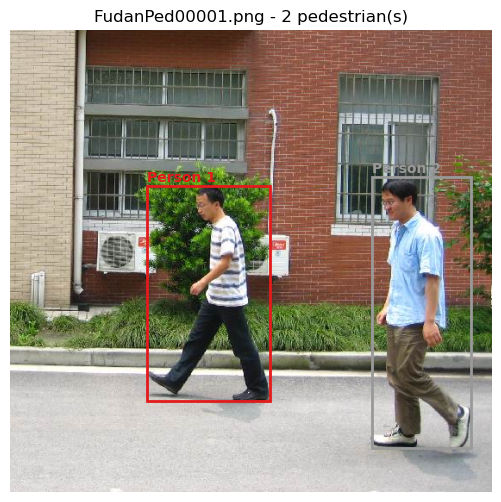

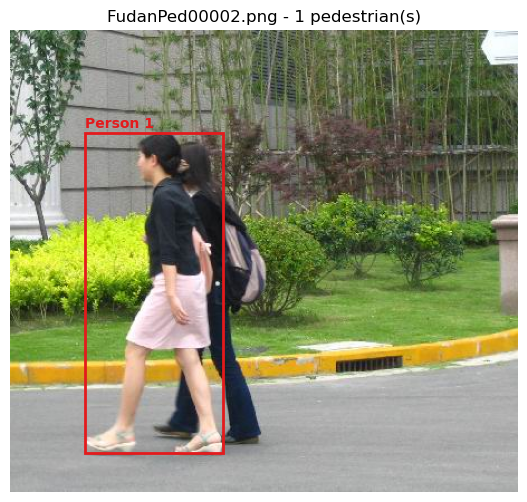

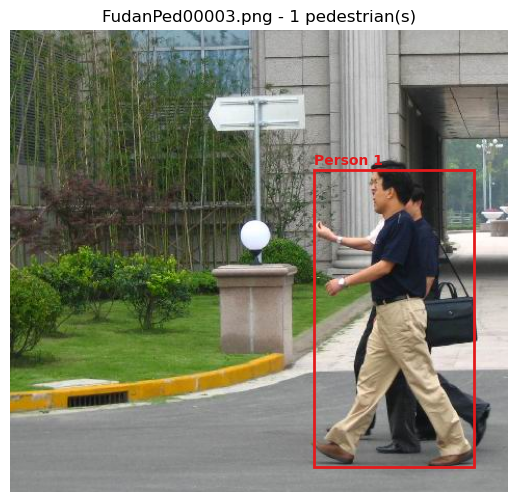

In [5]:
# Visualize bounding boxes on an image
def visualize_bboxes(img_path, mask_path):
    """Display image with bounding boxes drawn from the mask."""
    img = Image.open(img_path)
    boxes, num_peds = get_bboxes_from_mask(mask_path)
    
    fig, ax = plt.subplots(1, figsize=(8, 6))
    ax.imshow(img)
    
    colors = plt.cm.Set1(np.linspace(0, 1, max(num_peds, 1)))
    for i, box in enumerate(boxes):
        x_min, y_min, x_max, y_max = box
        rect = patches.Rectangle(
            (x_min, y_min), x_max - x_min, y_max - y_min,
            linewidth=2, edgecolor=colors[i], facecolor='none'
        )
        ax.add_patch(rect)
        ax.text(x_min, y_min - 5, f'Person {i+1}', color=colors[i],
                fontsize=10, fontweight='bold')
    
    ax.set_title(f'{os.path.basename(img_path)} - {num_peds} pedestrian(s)')
    ax.axis('off')
    plt.show()

# Visualize first 3 samples
for i in range(3):
    visualize_bboxes(
        os.path.join(img_dir, img_files[i]),
        os.path.join(mask_dir, mask_files[i])
    )

## 5. Create a Custom PyTorch Dataset

In [6]:
class PennFudanDataset(torch.utils.data.Dataset):
    """
    Custom dataset for the Penn-Fudan Pedestrian Detection dataset.
    
    Each sample returns:
        - image: a PIL Image converted to a tensor
        - target: a dict containing:
            - boxes (FloatTensor[N, 4]): bounding boxes in [x_min, y_min, x_max, y_max] format
            - labels (Int64Tensor[N]): class labels (1 = pedestrian)
            - masks (UInt8Tensor[N, H, W]): segmentation masks for each instance
            - image_id (Int64Tensor[1]): unique image identifier
            - area (FloatTensor[N]): area of each bounding box
            - iscrowd (Int64Tensor[N]): whether each instance is a crowd region
    """
    
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        
        # Load all image and mask file paths, sorted to ensure alignment
        self.imgs = sorted(os.listdir(os.path.join(root, 'PNGImages')))
        self.masks = sorted(os.listdir(os.path.join(root, 'PedMasks')))
    
    def __getitem__(self, idx):
        # Load image and mask
        img_path = os.path.join(self.root, 'PNGImages', self.imgs[idx])
        mask_path = os.path.join(self.root, 'PedMasks', self.masks[idx])
        
        img = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path)
        mask_np = np.array(mask)
        
        # Get unique object instances (0 is background)
        obj_ids = np.unique(mask_np)
        obj_ids = obj_ids[obj_ids != 0]
        
        # Create binary masks for each instance
        masks = (mask_np == obj_ids[:, None, None]).astype(np.uint8)
        
        # Compute bounding boxes from masks
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            x_min = int(np.min(pos[1]))
            x_max = int(np.max(pos[1]))
            y_min = int(np.min(pos[0]))
            y_max = int(np.max(pos[0]))
            boxes.append([x_min, y_min, x_max, y_max])
        
        # Convert to tensors
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones((num_objs,), dtype=torch.int64)  # All are pedestrians (class 1)
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        
        target = {
            'boxes': boxes,
            'labels': labels,
            'masks': masks,
            'image_id': image_id,
            'area': area,
            'iscrowd': iscrowd
        }
        
        if self.transforms is not None:
            img = self.transforms(img)
        else:
            img = T.ToTensor()(img)
        
        return img, target
    
    def __len__(self):
        return len(self.imgs)

# Test the dataset
dataset = PennFudanDataset(dataset_root)
print(f"Dataset size: {len(dataset)}")

img, target = dataset[0]
print(f"Image shape: {img.shape}")
print(f"Number of pedestrians: {len(target['boxes'])}")
print(f"Bounding boxes: {target['boxes']}")
print(f"Labels: {target['labels']}")

Dataset size: 170
Image shape: torch.Size([3, 536, 559])
Number of pedestrians: 2
Bounding boxes: tensor([[159., 181., 301., 430.],
        [419., 170., 534., 485.]])
Labels: tensor([1, 1])


## 6. Create Train/Validation Split and Data Loaders

In [7]:
def get_transform(train):
    """Define transforms for training and validation."""
    transforms = [T.ToTensor()]
    if train:
        # You can add data augmentation here for training
        # e.g., T.RandomHorizontalFlip(0.5)
        pass
    return T.Compose(transforms)

def collate_fn(batch):
    """Custom collate function for variable-size targets."""
    return tuple(zip(*batch))

# Create full dataset
dataset_full = PennFudanDataset(dataset_root, transforms=get_transform(train=True))

# Split into train and validation sets (80/20 split)
torch.manual_seed(42)
total_size = len(dataset_full)
train_size = int(0.8 * total_size)
val_size = total_size - train_size

indices = torch.randperm(total_size).tolist()
train_dataset = torch.utils.data.Subset(dataset_full, indices[:train_size])
val_dataset = torch.utils.data.Subset(dataset_full, indices[train_size:])

print(f"Total samples: {total_size}")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

# Create data loaders
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=2,
    shuffle=True,
    num_workers=2,
    collate_fn=collate_fn
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=2,
    shuffle=False,
    num_workers=2,
    collate_fn=collate_fn
)

# Verify a batch
images, targets = next(iter(train_loader))
print(f"\nBatch check:")
print(f"  Number of images in batch: {len(images)}")
print(f"  First image shape: {images[0].shape}")
print(f"  First target keys: {targets[0].keys()}")

Total samples: 170
Training samples: 136
Validation samples: 34

Batch check:
  Number of images in batch: 2
  First image shape: torch.Size([3, 320, 375])
  First target keys: dict_keys(['boxes', 'labels', 'masks', 'image_id', 'area', 'iscrowd'])


In [12]:
#TODO: Your code here